# AI and ML for Coders
Exercises from Laurence Moroney's ORA book.  Attempting to use [keras-core](https://keras.io/keras_core/announcement/) and JAX.

This notebook: autoencoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 

In [3]:
os.environ['KERAS_BACKEND'] = 'jax'

In [32]:
BACKEND = os.environ['KERAS_BACKEND']

In [4]:
from startup import np, pd, plt, sns
from startup_gui import widgets, interact, interactive
from journal_20231025_keras_core_jax_metal import wrap_jax_metal

In [5]:
import keras_core as keras

Using JAX backend.


In [6]:
Sequential = keras.Sequential
Dense = keras.layers.Dense
Input = keras.layers.Input
Flatten = keras.layers.Flatten

# Fashion MNIST

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [8]:
# Scaling to 0 - 1 range (do this outside training loop)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_test.shape

(10000, 28, 28)

In [10]:
def create_fashion_image_eda_plot(X, y):
    def inner(i):
        ax = plt.imshow(X[i, ...])
        plt.title(y[i])
    return inner

interactive(create_fashion_image_eda_plot(X_train, y_train), i=widgets.IntSlider(label='Image: ', min=0, max=X_train.shape[0], value=0))

interactive(children=(IntSlider(value=0, description='i', max=60000), Output()), _dom_classes=('widget-interac…

In [11]:
def create_fashion_label_eda_plot(X, y):
    def inner(label):
        ind = y == label
        X_f = np.vstack(np.split(
            np.hstack(X[ind, ...][:9, ...]),
            3, axis=1
        ))
        ax = plt.imshow(X_f)
        plt.title(label)
    return inner


interactive(create_fashion_label_eda_plot(X_train, y_train), label=widgets.IntSlider(label='Label: ', min=0, max=9, value=0))

interactive(children=(IntSlider(value=0, description='label', max=9), Output()), _dom_classes=('widget-interac…

In [12]:
class SufficientAccuracyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            if logs.get('accuracy') >= 0.95:
                print("\nReached 95% accuracy so cancelling training!") 
                self.model.stop_training = True
        

In [13]:
accuracy_callback = SufficientAccuracyCallback()

## Some EDA on the data density distributions 
In preparation to doing some modelling with TensorFlow Probability

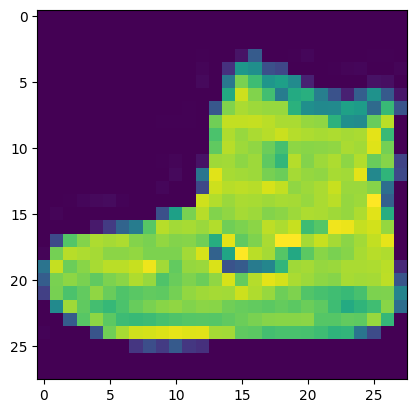

In [14]:
plt.imshow(pd.DataFrame(X_train[0,:, :], index=pd.MultiIndex.from_arrays([np.arange(28), np.arange(28)])).values)

In [15]:
n_px = 28
ind = np.arange(n_px)
n_im = X_train.shape[0]
df = pd.DataFrame({
    'im': np.repeat(np.arange(n_im), n_px*n_px),
    'x': np.tile(np.tile(ind, n_px), n_im), 
    'y': np.tile(np.repeat(ind, n_px), n_im),
    'v': X_train.flatten(),
    'label': np.repeat(y_train, n_px*n_px)
})

In [16]:
df.shape

(47040000, 5)

<Axes: >

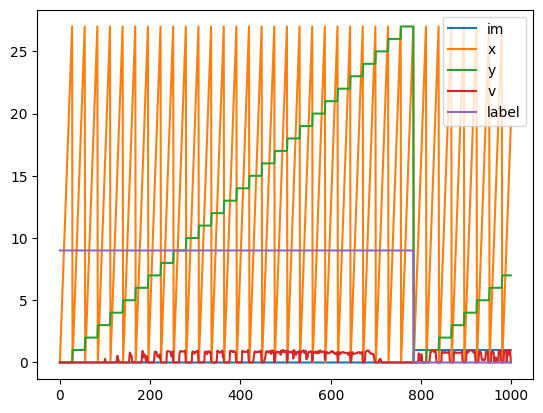

In [17]:
df.head(1000).plot()

In [18]:
interactive(
    lambda label: plt.imshow(df.query(f'label == {label}').groupby(['y', 'x']).v.mean().values.reshape(n_px, n_px)),
    label=np.arange(0,10)
)

interactive(children=(Dropdown(description='label', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()…

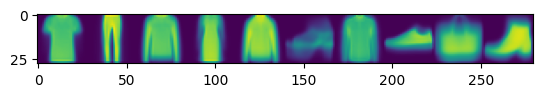

In [19]:
plt.imshow(df.groupby(['label', 'x', 'y']).v.mean().unstack().values.T)

## Convolutional Neural Network

In [20]:
encoder = Sequential(
    [
        keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
        keras.layers.MaxPooling2D(2, 2),
    ]
)

model_conv = Sequential(
    [
        Input(shape=(28, 28, 1)), 
        encoder,
        Flatten(),
        Dense(128, activation=keras.activations.relu),
        Dense(10, activation=keras.activations.softmax)
    ]
)

2023-10-30 18:12:53.989625: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
2023-10-30 18:12:54.002 Python[7778:192329] apply_selection_policy_once: avoid use of removable GPUs (via org.python.python:GPUSelectionPolicy->avoidRemovable)


Metal device set to: Apple M2


In [21]:
model_conv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_conv = wrap_jax_metal(model_conv)

In [22]:
encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)        │        640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)          │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 37,568 (146.75 KB)

 Trainable params: 37,568 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_conv.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 5, 5, 64)          │     37,568 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    204,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 243,786 (952.29 KB)

 Trainable params: 243,786 (952.29 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# model_conv.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[accuracy_callback])

In [25]:
# model_conv.evaluate(X_test, y_test)

# Convolutional Autoencoder

In [26]:
encoder = Sequential(
    [
        keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu, padding='same'),  # input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.MaxPooling2D(2, 2),
    ]
)
encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
decoder = Sequential(
    [
        keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu, padding='same'), # input_shape=(7,7,64)),
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(1, (3, 3), activation=keras.activations.sigmoid, padding='same'),
    ]
)
decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d (UpSampling2D)    │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
model_auto_conv = Sequential(
    [
        Input(shape=(28, 28, 1)), 
        encoder,
        decoder
    ]
)

In [29]:
model_auto_conv.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 7, 7, 64)          │     37,568 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_3 (Sequential)       │ (None, 28, 28, 1)         │     74,433 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_auto_conv.compile(optimizer='adam', loss='binary_crossentropy')
model_auto_conv = wrap_jax_metal(model_auto_conv)

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=BACKEND + '_' + "model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

In [34]:
model_auto_conv.fit(
    X_train, X_train, epochs=20, batch_size=32, callbacks=callbacks, 
    validation_split=0.15,
)

Epoch 1/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2944

objc[7778]: Class MetalStreamWrapper is implemented in both /Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/jax_plugins/metal_plugin/pjrt_plugin_metal_14.dylib (0x2f2241228) and /Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/tensorflow-plugins/libmetal_plugin.dylib (0x3acfd1638). One of the two will be used. Which one is undefined.


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 105s 66ms/step - loss: 0.2943 - val_loss: 0.2583
Epoch 2/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - loss: 0.2556 - val_loss: 0.2537
Epoch 3/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - loss: 0.2520 - val_loss: 0.2528
Epoch 4/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - loss: 0.2504 - val_loss: 0.2513
Epoch 5/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - loss: 0.2486 - val_loss: 0.2502
Epoch 6/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - loss: 0.2485 - val_loss: 0.2497
Epoch 7/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - loss: 0.2475 - val_loss: 0.2493
Epoch 8/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - loss: 0.2477 - val_loss: 0.2491
Epoch 9/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - loss: 0.2469 - val_loss: 0.2488
Epoch 10/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - loss: 0.2477 - val_loss: 0.2485
Epoch 11/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - loss: 0.2468 - val_loss: 0.2483
Epoch 12

In [51]:
def plot_autoenconder(model, X):
    def inner(i):
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(X[i,...])
        X_pred = model.predict(X[i,...].reshape(1, 28,28,1)).reshape(28,28)
        ax[1].imshow(X_pred)
        ax[2].imshow(np.abs(X_pred - X[i, ...]))

    return inner

In [52]:
interactive(plot_autoenconder(model_auto_conv, X_test), i=np.arange(X_test.shape[0]))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [50]:
model_auto_conv.save('fashion_mnist_64_64_autoencoder_20231030.keras')

In [70]:
encoder_16_8_8 = Sequential(
    [
        keras.layers.Conv2D(16, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
        keras.layers.Conv2D(8, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
        keras.layers.Conv2D(8, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
    ]
)
decoder_8_8_16 = Sequential(
    [
        keras.layers.Conv2D(8, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(8, (3, 3), activation=keras.activations.relu, padding='same'),
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(16, (3, 3), activation=keras.activations.relu),  # NB: no 'same' padding so we get 28x28
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(1, (3, 3), activation=keras.activations.sigmoid, padding='same'),
    ]
)
model_auto_conv_16_8_8 = Sequential(
    [
        Input(shape=(28, 28, 1)), 
        encoder_16_8_8,
        decoder_8_8_16
    ]
)

In [71]:
model_auto_conv_16_8_8.compile(optimizer='adam', loss='binary_crossentropy')
model_auto_conv_16_8_8 = wrap_jax_metal(model_auto_conv_16_8_8)

In [72]:
callbacks_16_8_8 = [
    keras.callbacks.ModelCheckpoint(filepath=BACKEND + '_' + "_autoencoder_16_8_8_model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

In [73]:
model_auto_conv_16_8_8.fit(
    X_train, X_train, epochs=20, batch_size=32, callbacks=callbacks_16_8_8, 
    validation_split=0.15,
)

Epoch 1/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 112s 69ms/step - loss: 0.3624 - val_loss: 0.3022
Epoch 2/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 109s 68ms/step - loss: 0.2975 - val_loss: 0.2945
Epoch 3/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 109s 69ms/step - loss: 0.2919 - val_loss: 0.2916
Epoch 4/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - loss: 0.2884 - val_loss: 0.2889
Epoch 5/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - loss: 0.2865 - val_loss: 0.2873
Epoch 6/20
 133/1594 ━━━━━━━━━━━━━━━━━━━━ 1:29 61ms/step - loss: 0.2819

KeyboardInterrupt: 